In [59]:
# This notebook contains a naive mlp for garbage classification
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import utils
from vocab import Vocabulary
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu") 
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import os
EMB_DIM = 100 # embedding dimension to be used, choose from [50, 100, 200, 300]
glove_path = os.path.expanduser('./glove.6B.{}d.txt'.format(EMB_DIM))
embedding_dict = utils.load_glove_to_dict(glove_path)

400000it [00:09, 43202.57it/s]


In [61]:
MAX_SEQ_LEN = 10 # The maximum input sequence length, if longer, truncate; if shorter, pad

complete_csv_path = './preprocessed.csv'
complete_df = pd.read_csv(complete_csv_path)

complete_vocab = utils.build_vocab(complete_df)

wvecs = utils.build_wvecs(embedding_dict, complete_vocab)

train_csv_path = './train.csv'
val_csv_path = './val.csv'
test_csv_path = './test.csv'

In [62]:
# Load dataset
train_dataset = utils.GarbageDataset(train_csv_path, complete_vocab, MAX_SEQ_LEN)
val_dataset = utils.GarbageDataset(val_csv_path, complete_vocab, MAX_SEQ_LEN)
test_dataset = utils.GarbageDataset(test_csv_path, complete_vocab, MAX_SEQ_LEN)

# Construct dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=utils.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=utils.collate_fn)

In [63]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, seq_length, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(RNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc1 = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        #embeds = self.conv1(embeds)
        #print(embeds.shape)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = F.relu(self.fc1(out))
        out = out.view(batch_size,self.seq_length,self.output_size)
        out = out[:, -1] 
        
        return out, hidden
    

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if use_cuda:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [64]:
def eval(loader: DataLoader, model):
    """Evaluate the classification accuracy of model on the given dataset

    Args:
        loader (DataLoader): 
        model ([type])
    """
    correct_counts = 0
    loss_sum = 0
    with torch.no_grad():
        for batch in loader:
            input, target = batch
            input, target = input.to(device), target.to(device)
            batch_size = input.size(0)
            h = net.init_hidden(batch_size)
            h = tuple([each.data for each in h])
            pred, h = net(input, h)
            pred_classes = torch.argmax(pred, dim=1)
            correct_counts += torch.sum(pred_classes == target)
            loss = loss_fn(pred, target.long())
            loss_sum += loss.item() * target.shape[0]
    # print(correct_counts.item() / len(loader.dataset))
    return correct_counts.item() / len(loader.dataset), loss_sum / len(loader.dataset)

In [65]:
def eval_classes(loader: DataLoader, model):
    """Evaluate the classification accuracy of model on the given dataset

    Args:
        loader (DataLoader): 
        model ([type])
    """
    correct_counts = [0] * 4
    class_counts = [0] * 4
    with torch.no_grad():
        for batch in loader:
            input, target = batch
            input, target = input.to(device), target.to(device)
            batch_size = input.size(0)
            h = net.init_hidden(batch_size)
            h = tuple([each.data for each in h])
            pred, h = net(input, h)
            pred_classes = torch.argmax(pred, dim=1)
            for i in range(4):
                i_class_index = torch.where(target == i)[0]
                if len(i_class_index) != 0:
                    correct_counts[i] += torch.sum(pred_classes[i_class_index] == target[i_class_index])
                    class_counts[i] += len(i_class_index)
    # print(correct_counts.item() / len(loader.dataset))
    # print(correct_counts, class_counts)
    return [x/y for x,y in zip(correct_counts, class_counts)], class_counts

In [66]:
use_glove = False

output_size = 4
embedding_dim = 100
hidden_dim = 128
n_layers = 4

net = RNN(len(complete_vocab), output_size, embedding_dim, hidden_dim, n_layers, MAX_SEQ_LEN).to(device)

if use_glove:   
    net.embedding.weight.data.copy_(torch.from_numpy(np.array(wvecs)))
max_epoch = 100

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

train_acc_stats = []
val_acc_stats = []
test_acc_stats = []
train_loss_stats = []
val_loss_stats = []
test_loss_stats = []

best_test_acc = 0

print('Start training')
for epoch in range(max_epoch):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        batch_size = input.shape[0]
        h = net.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        pred, h = net(input, h)
        loss = loss_fn(pred, target.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * target.shape[0]
    net.eval()
    val_acc, val_loss = eval(val_loader, net)
    train_acc, train_loss = eval(train_loader, net)
    test_acc, test_loss = eval(test_loader, net)
    val_acc_stats.append(val_acc)
    val_loss_stats.append(val_loss)
    train_acc_stats.append(train_acc)
    train_loss_stats.append(train_loss)
    test_acc_stats.append(test_acc)
    test_loss_stats.append(test_loss)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    print('Epoch:{}\tTrain Loss:{:4f}\tTrain Acc:{:4f}\tVal Loss:{:4f}\tVal Acc:{:4f}\tTest Loss:{:4f}\tTest Acc:{:4f}\tBest Test Acc:{:4f}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc,test_loss,test_acc,best_test_acc))



Start training
Epoch:1	Train Loss:1.153294	Train Acc:0.454775	Val Loss:1.157607	Val Acc:0.417303	Test Loss:1.181776	Test Acc:0.418136	Best Test Acc:0.418136
Epoch:2	Train Loss:1.032477	Train Acc:0.519292	Val Loss:1.091557	Val Acc:0.496183	Test Loss:1.151759	Test Acc:0.465995	Best Test Acc:0.465995
Epoch:3	Train Loss:0.934936	Train Acc:0.561354	Val Loss:1.047754	Val Acc:0.531807	Test Loss:1.135346	Test Acc:0.508816	Best Test Acc:0.508816
Epoch:4	Train Loss:0.832222	Train Acc:0.660658	Val Loss:1.060522	Val Acc:0.531807	Test Loss:1.127711	Test Acc:0.526448	Best Test Acc:0.526448
Epoch:5	Train Loss:0.699344	Train Acc:0.723909	Val Loss:0.995286	Val Acc:0.569975	Test Loss:1.078260	Test Acc:0.559194	Best Test Acc:0.559194
Epoch:6	Train Loss:0.636435	Train Acc:0.761860	Val Loss:0.994630	Val Acc:0.610687	Test Loss:1.062996	Test Acc:0.614610	Best Test Acc:0.614610
Epoch:7	Train Loss:0.573870	Train Acc:0.794750	Val Loss:0.985392	Val Acc:0.608142	Test Loss:1.029488	Test Acc:0.617128	Best Test Acc:

In [67]:
net.eval()
test_acc, test_loss = eval(test_loader, net)
print('Test Acc:{}'.format(test_acc))

Test Acc:0.690176322418136


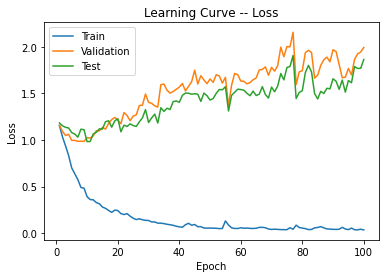

In [68]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Loss')
plt.plot(E, train_loss_stats, label='Train')
plt.plot(E, val_loss_stats, label='Validation')
plt.plot(E, test_loss_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

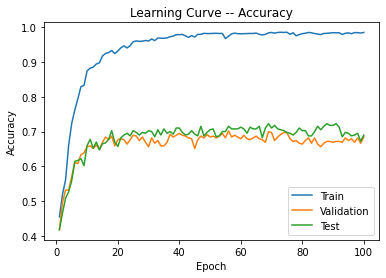

In [69]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Accuracy')
plt.plot(E, train_acc_stats, label='Train')
plt.plot(E, val_acc_stats, label='Validation')
plt.plot(E, test_acc_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [70]:
class_train_acc, class_train_count = eval_classes(train_loader, net)
print('Accuracy of each class on Training set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_train_acc[0],class_train_acc[1],class_train_acc[2],class_train_acc[3]))
print('Amount of each class on Training set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_train_count[0],class_train_count[1],class_train_count[2],class_train_count[3]))
class_test_acc, class_test_count = eval_classes(test_loader, net)
print('Accuracy of each class on Test set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_test_acc[0],class_train_acc[1],class_test_acc[2],class_test_acc[3]))
print('Amount of each class on Test set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_test_count[0],class_test_count[1],class_test_count[2],class_test_count[3]))

Accuracy of each class on Training set. hazardous wast:0.969608	recyclable waste:0.985000	household food waste:0.987730	residual waste:0.997338
Amount of each class on Training set. hazardous wast:1020	recyclable waste:200	household food waste:815	residual waste:1127
Accuracy of each class on Test set. hazardous wast:0.663636	recyclable waste:0.985000	household food waste:0.684211	residual waste:0.727273
Amount of each class on Test set. hazardous wast:110	recyclable waste:19	household food waste:114	residual waste:154


In [71]:
use_glove = True

output_size = 4
embedding_dim = 100
hidden_dim = 128
n_layers = 2

net = RNN(len(complete_vocab), output_size, embedding_dim, hidden_dim, n_layers, MAX_SEQ_LEN).to(device)

if use_glove:   
    net.embedding.weight.data.copy_(torch.from_numpy(np.array(wvecs)))
max_epoch = 100

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

train_acc_stats = []
val_acc_stats = []
test_acc_stats = []
train_loss_stats = []
val_loss_stats = []
test_loss_stats = []
best_test_acc = 0
print('Start training')
for epoch in range(max_epoch):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        batch_size = input.shape[0]
        h = net.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        pred, h = net(input, h)
        loss = loss_fn(pred, target.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * target.shape[0]
    net.eval()
    val_acc, val_loss = eval(val_loader, net)
    train_acc, train_loss = eval(train_loader, net)
    test_acc, test_loss = eval(test_loader, net)
    val_acc_stats.append(val_acc)
    val_loss_stats.append(val_loss)
    train_acc_stats.append(train_acc)
    train_loss_stats.append(train_loss)
    test_acc_stats.append(test_acc)
    test_loss_stats.append(test_loss)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    print('Epoch:{}\tTrain Loss:{:4f}\tTrain Acc:{:4f}\tVal Loss:{:4f}\tVal Acc:{:4f}\tTest Loss:{:4f}\tTest Acc:{:4f}\tBest Test Acc:{:4f}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc,test_loss,test_acc,best_test_acc))

Start training
Epoch:1	Train Loss:1.373064	Train Acc:0.322581	Val Loss:1.366904	Val Acc:0.343511	Test Loss:1.387996	Test Acc:0.277078	Best Test Acc:0.277078
Epoch:2	Train Loss:1.372667	Train Acc:0.322581	Val Loss:1.366468	Val Acc:0.343511	Test Loss:1.388333	Test Acc:0.277078	Best Test Acc:0.277078
Epoch:3	Train Loss:1.298010	Train Acc:0.322897	Val Loss:1.325124	Val Acc:0.343511	Test Loss:1.355805	Test Acc:0.274559	Best Test Acc:0.277078
Epoch:4	Train Loss:1.106945	Train Acc:0.525933	Val Loss:1.227499	Val Acc:0.458015	Test Loss:1.179961	Test Acc:0.488665	Best Test Acc:0.488665
Epoch:5	Train Loss:1.050313	Train Acc:0.547438	Val Loss:1.192086	Val Acc:0.475827	Test Loss:1.191052	Test Acc:0.501259	Best Test Acc:0.501259
Epoch:6	Train Loss:0.916102	Train Acc:0.589184	Val Loss:1.115922	Val Acc:0.506361	Test Loss:1.115528	Test Acc:0.506297	Best Test Acc:0.506297
Epoch:7	Train Loss:0.833243	Train Acc:0.636622	Val Loss:1.079284	Val Acc:0.539440	Test Loss:1.102268	Test Acc:0.493703	Best Test Acc:

In [72]:
net.eval()
test_acc, test_loss = eval(test_loader, net)
print('Test Acc:{}'.format(test_acc))

Test Acc:0.690176322418136


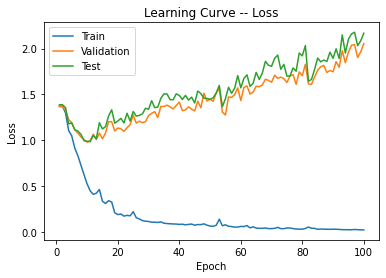

In [73]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Loss')
plt.plot(E, train_loss_stats, label='Train')
plt.plot(E, val_loss_stats, label='Validation')
plt.plot(E, test_loss_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

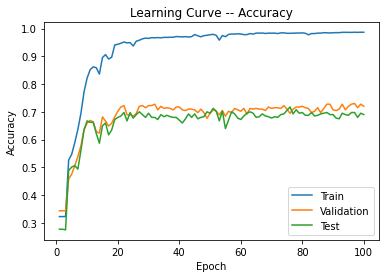

In [74]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Accuracy')
plt.plot(E, train_acc_stats, label='Train')
plt.plot(E, val_acc_stats, label='Validation')
plt.plot(E, test_acc_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [75]:
class_train_acc, class_train_count = eval_classes(train_loader, net)
print('Accuracy of each class on Training set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_train_acc[0],class_train_acc[1],class_train_acc[2],class_train_acc[3]))
print('Amount of each class on Training set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_train_count[0],class_train_count[1],class_train_count[2],class_train_count[3]))
class_test_acc, class_test_count = eval_classes(test_loader, net)
print('Accuracy of each class on Test set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_test_acc[0],class_train_acc[1],class_test_acc[2],class_test_acc[3]))
print('Amount of each class on Test set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_test_count[0],class_test_count[1],class_test_count[2],class_test_count[3]))

Accuracy of each class on Training set. hazardous wast:0.974510	recyclable waste:0.990000	household food waste:0.998773	residual waste:0.989352
Amount of each class on Training set. hazardous wast:1020	recyclable waste:200	household food waste:815	residual waste:1127
Accuracy of each class on Test set. hazardous wast:0.636364	recyclable waste:0.990000	household food waste:0.710526	residual waste:0.733766
Amount of each class on Test set. hazardous wast:110	recyclable waste:19	household food waste:114	residual waste:154


In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        # self.alpha = alpha
        # if isinstance(alpha, (float, int, torch.long)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        # if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [77]:
use_glove = True

output_size = 4
embedding_dim = 100
hidden_dim = 128
n_layers = 2

net = RNN(len(complete_vocab), output_size, embedding_dim, hidden_dim, n_layers, MAX_SEQ_LEN).to(device)

if use_glove:   
    net.embedding.weight.data.copy_(torch.from_numpy(np.array(wvecs)))
max_epoch = 100

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

trainfocalgama = 0.5

train_acc_stats = []
val_acc_stats = []
test_acc_stats = []
train_loss_stats = []
val_loss_stats = []
test_loss_stats = []
best_test_acc = 0
print('Start training')
for epoch in range(max_epoch):
    net.train()
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input, target = batch
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        batch_size = input.shape[0]
        h = net.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        pred, h = net(input, h)
        loss = FocalLoss(gamma=trainfocalgama)(pred, target.long())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * target.shape[0]
    net.eval()
    val_acc, val_loss = eval(val_loader, net)
    train_acc, train_loss = eval(train_loader, net)
    test_acc, test_loss = eval(test_loader, net)
    val_acc_stats.append(val_acc)
    val_loss_stats.append(val_loss)
    train_acc_stats.append(train_acc)
    train_loss_stats.append(train_loss)
    test_acc_stats.append(test_acc)
    test_loss_stats.append(test_loss)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
    print('Epoch:{}\tTrain Loss:{:4f}\tTrain Acc:{:4f}\tVal Loss:{:4f}\tVal Acc:{:4f}\tTest Loss:{:4f}\tTest Acc:{:4f}\tBest Test Acc:{:4f}'.format(
        epoch+1, train_loss, train_acc, val_loss, val_acc,test_loss,test_acc,best_test_acc))

Start training


<ipython-input-76-2726ad9fa9af>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


Epoch:1	Train Loss:1.258667	Train Acc:0.356420	Val Loss:1.224337	Val Acc:0.358779	Test Loss:1.235084	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:2	Train Loss:1.258627	Train Acc:0.356420	Val Loss:1.225357	Val Acc:0.358779	Test Loss:1.241132	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:3	Train Loss:1.247894	Train Acc:0.356420	Val Loss:1.214911	Val Acc:0.358779	Test Loss:1.231025	Test Acc:0.387909	Best Test Acc:0.387909
Epoch:4	Train Loss:1.073128	Train Acc:0.490512	Val Loss:1.099775	Val Acc:0.460560	Test Loss:1.152143	Test Acc:0.476071	Best Test Acc:0.476071
Epoch:5	Train Loss:0.872228	Train Acc:0.585073	Val Loss:0.988530	Val Acc:0.483461	Test Loss:1.005999	Test Acc:0.546599	Best Test Acc:0.546599
Epoch:6	Train Loss:0.808572	Train Acc:0.631562	Val Loss:1.005578	Val Acc:0.506361	Test Loss:1.036327	Test Acc:0.541562	Best Test Acc:0.546599
Epoch:7	Train Loss:0.729427	Train Acc:0.672676	Val Loss:0.997779	Val Acc:0.567430	Test Loss:1.005271	Test Acc:0.549118	Best Test Acc:0.549118
Epoch:

In [78]:
net.eval()
test_acc, test_loss = eval(test_loader, net)
print('Test Acc:{}'.format(test_acc))

Test Acc:0.7153652392947103


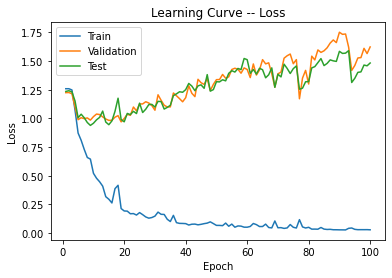

In [79]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Loss')
plt.plot(E, train_loss_stats, label='Train')
plt.plot(E, val_loss_stats, label='Validation')
plt.plot(E, test_loss_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

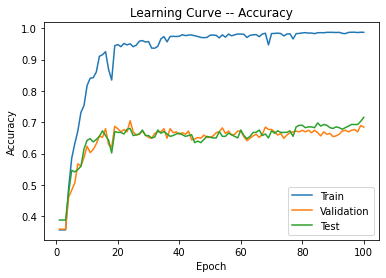

In [80]:
import matplotlib.pyplot as plt
plt.figure()
E = np.arange(1, max_epoch+1,1)
plt.title('Learning Curve -- Accuracy')
plt.plot(E, train_acc_stats, label='Train')
plt.plot(E, val_acc_stats, label='Validation')
plt.plot(E, test_acc_stats, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [81]:
class_train_acc, class_train_count = eval_classes(train_loader, net)
print('Accuracy of each class on Training set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_train_acc[0],class_train_acc[1],class_train_acc[2],class_train_acc[3]))
print('Amount of each class on Training set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_train_count[0],class_train_count[1],class_train_count[2],class_train_count[3]))
class_test_acc, class_test_count = eval_classes(test_loader, net)
print('Accuracy of each class on Test set. hazardous wast:{:4f}\trecyclable waste:{:4f}\thousehold food waste:{:4f}\tresidual waste:{:4f}'.format(class_test_acc[0],class_train_acc[1],class_test_acc[2],class_test_acc[3]))
print('Amount of each class on Test set. hazardous wast:{}\trecyclable waste:{}\thousehold food waste:{}\tresidual waste:{}'.format(class_test_count[0],class_test_count[1],class_test_count[2],class_test_count[3]))

Accuracy of each class on Training set. hazardous wast:0.973529	recyclable waste:0.970000	household food waste:0.998773	residual waste:0.992902
Amount of each class on Training set. hazardous wast:1020	recyclable waste:200	household food waste:815	residual waste:1127
Accuracy of each class on Test set. hazardous wast:0.727273	recyclable waste:0.970000	household food waste:0.675439	residual waste:0.746753
Amount of each class on Test set. hazardous wast:110	recyclable waste:19	household food waste:114	residual waste:154
